Diffusion Limited Aggregation (DLA)

* growth model based on diffusing particles
* started with a single seed
* can be modeled by 
    * solving the time independent diffusion equation (Laplace equation)
    * locating growth candidates around the cluster (north, south, east, west)
    * assigning a growth probability $p_{g}$ for each growth candidate as a function of the concentration of diffusing nutrients at that growth location
    
        $p_{g}(i,j) = c^{\eta}_{i,j}/\sum _{growth candidates} c^{\eta}_{i,j}$

        where $c_{i,j}$ is the concentration at site $(i,j)$
        
        $\eta$ controls the shape of the DLA cluster:
            
        $\eta = 1$ : Standard DLA cluster (branching)

        $\eta < 1$ : More compact ($\eta = 0$ resulting in eden cluster)
        
        $\eta > 1$ : More branched


    * selective a single growth candidate with probability $p_{g}$ and adding it to the cluster
    * re-solving the diffusion equation and repeating the process for the growth steps

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from scipy.optimize import minimize_scalar
from numba import njit

In [31]:
# params
size = 100
eta = 1
omega = 1.9
tolerance = 1e-5
iterations = 100
steps = 1000

# print full output
np.set_printoptions(threshold=np.inf, linewidth=200)


# grid
concentration = np.linspace(1, 0, size).reshape(-1, 1) * np.ones((size, size))
cluster = np.zeros((size, size), dtype=int)
cluster[-1, size // 2] = 1 # one seed, middle of bottom row

# Verify initialization
print(f"Number of cells in cluster: {np.sum(cluster == 1)}")
print(f"Seed position: {np.argwhere(cluster == 1)[0]}")

Number of cells in cluster: 1
Seed position: [99 50]


The Laplacian operator $\nabla^2$ in two dimensions is defined as:

$\nabla^2 c = \frac{\partial^2 c}{\partial x^2} + \frac{\partial^2 c}{\partial y^2}$

For a 2D grid, this can be approximated using finite differences as:

$\nabla^2 c_{i,j} \approx c_{i+1,j} + c_{i-1,j} + c_{i,j+1} + c_{i,j-1} - 4c_{i,j}$

This formula tells us that each point in the grid is updated based on its four neighbors


The 5-point stencil can be written as a matrix (convolution kernel):

$$
\begin{bmatrix}
  0 &  1 &  0 \\
  1 & -4 &  1 \\
  0 &  1 &  0
\end{bmatrix}
$$


In [32]:
# functions
#@njit
def solve_sor(concentration, cluster, omega, tolerance, iterations): # calculate residual for non-cluster points only
    laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1],[0, 1, 0]])
    mask = cluster == 0
    for _ in range(iterations):
        old_concentration = concentration.copy()
        residual = convolve(concentration, laplacian_kernel, mode='constant')[mask]
        
        # More efficient update
        concentration[mask] += omega * np.clip(residual / 4, -1e10, 1e10)
        
        if np.linalg.norm(concentration[mask] - old_concentration[mask]) < tolerance:
            break
    return concentration



def find_growth(cluster):
    rows, cols = cluster.shape  # for dynamic
    candidates = []
    neighbours = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # NSEW directions
    
    cluster_cells = np.argwhere(cluster == 1)
    
    # debug
    print(f"Number of cluster cells: {len(cluster_cells)}")
    #print(f"Cluster cells positions: {cluster_cells}")
    
    for cell in cluster_cells:
        x, y = cell
        for dx, dy in neighbours:
            nx, ny = x + dx, y + dy
            
            if 0 <= nx < rows and 0 <= ny < cols:   # check neighbour is correct
                if cluster[nx, ny] == 0:    # check is empty
                    candidate = [nx, ny]
                    if candidate not in candidates:   # check unique
                        candidates.append(candidate)
                        # debug
                        print(f"Added candidate at ({nx}, {ny})")
    
    candidates = np.array(candidates)
    # debug
    print(f"Total candidates found: {len(candidates)}")
    return candidates


        
def compute_growth_probabilities(concentration, candidates, eta):
    candidate_concentrations = np.maximum(concentration[candidates[:, 0], candidates[:, 1]], 1e-10)  # no zero values
    weighted_concentrations = candidate_concentrations ** eta
    sum_weighted = np.sum(weighted_concentrations)

    return weighted_concentrations / sum_weighted if sum_weighted > 1e-10 else np.full(len(candidates), 1 / len(candidates))



def simulation(cluster, concentration, steps, eta, omega):
    initial_ones = np.sum(cluster == 1) # double check starting cluster
    if initial_ones != 1:
        raise ValueError(f"Found {initial_ones} cells in starting cluster, should be 1")
    
    for step in range(steps):
        print(f"\nStep {step}")
        concentration = solve_sor(concentration, cluster, omega, tolerance, iterations)
        
        candidates = find_growth(cluster)
        if len(candidates) == 0:
            break
            
        probability = compute_growth_probabilities(concentration, candidates, eta)
        
        choice = np.random.choice(len(candidates), p=probability)
        x, y = candidates[choice]
        
        # debug
        print(f"Selected candidate at ({x}, {y}) with probability {probability[choice]}")
        cluster[x, y] = 1
    
    return cluster, concentration


Step 0
Number of cluster cells: 1
Added candidate at (99, 51)
Added candidate at (99, 49)
Added candidate at (98, 50)
Total candidates found: 3
Selected candidate at (99, 49) with probability 0.33333333333333337

Step 1
Number of cluster cells: 2
Added candidate at (99, 48)
Added candidate at (98, 49)
Added candidate at (99, 51)
Added candidate at (98, 50)
Total candidates found: 4
Selected candidate at (99, 48) with probability 0.4375804823192644

Step 2
Number of cluster cells: 3
Added candidate at (99, 47)
Added candidate at (98, 48)
Added candidate at (98, 49)
Added candidate at (99, 51)
Added candidate at (98, 50)
Total candidates found: 5
Selected candidate at (98, 49) with probability 1.0

Step 3
Number of cluster cells: 4
Added candidate at (98, 50)
Added candidate at (98, 48)
Added candidate at (97, 49)
Added candidate at (99, 47)
Added candidate at (99, 51)
Total candidates found: 5
Selected candidate at (99, 47) with probability 0.19999999999999998

Step 4
Number of cluster

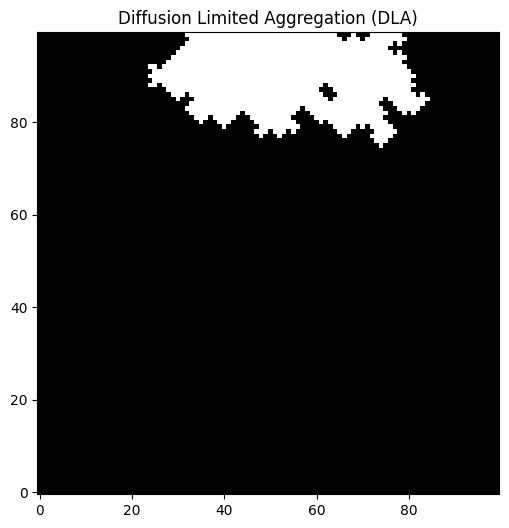

In [33]:
result_cluster, result_concentration = simulation(cluster, concentration, steps, eta, omega)
plt.figure(figsize=(6,6))
plt.imshow(result_cluster, cmap='gray', origin='lower')
plt.title("Diffusion Limited Aggregation (DLA)")
plt.axis('on')
plt.show()

something fucked up here ? ?